# Session 3: Markov Chain Monte Carlo

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from itertools import takewhile
import pymc as pm
import arviz as az
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import warnings
warnings.simplefilter("ignore")

import platform
if platform.system() == 'Linux':
    # Multiprocessing behaves oddly on Linux, so we need to set the start method
    import multiprocessing as mp
    mp.set_start_method('spawn', force=True)

## Bayesian Computation

Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

## Numerical Integration

Bayesian analysis often requires integration over multiple dimensions that is intractable both via analytic methods or standard methods of numerical integration.
However, it is often possible to compute these integrals by simulating
(drawing samples) from posterior distributions. For example, consider the expected value of a random variable $\mathbf{x}$:

$$E[\mathbf{x}] = \int \mathbf{x} f(\mathbf{x}) d\mathbf{x}, \qquad\mathbf{x} = x_1, \ldots ,x_k$$

where $k$ (the dimension of vector $x$) is perhaps very large. If we can produce a reasonable number of random vectors $\{{\bf x_i}\}$, we can use these values to approximate the unknown integral. This process is known as *Monte Carlo integration*. In general, MC integration allows integrals against probability density functions:

$$I = \int h(\mathbf{x}) f(\mathbf{x}) \mathbf{dx}$$

to be estimated by finite sums:

$$\hat{I} = \frac{1}{n}\sum_{i=1}^n h(\mathbf{x}_i),$$

where $\mathbf{x}_i$ is a sample from $f$. This estimate is valid and useful because:

-   By the strong law of large numbers:

$$\hat{I} \rightarrow I   \text{   with probability 1}$$

-   Simulation error can be measured and controlled:

$$Var(\hat{I}) = \frac{1}{n(n-1)}\sum_{i=1}^n (h(\mathbf{x}_i)-\hat{I})^2$$

### How is this relevant to Bayesian analysis? 

When we observe data $y$ that we hypothesize as being obtained from a sampling model $f(y|\theta)$, where $\theta$ is a vector of (unknown) model parameters, a Bayesian places a *prior* distribution $p(\theta)$ on the parameters to describe the uncertainty in the true values of the parameters. Bayesian inference, then, is obtained by calculating the *posterior* distribution, which is proportional to the product of these quantities:

$$p(\theta | y) \propto f(y|\theta) p(\theta)$$

unfortunately, for most problems of interest, the normalizing constant cannot be calculated because it involves mutli-dimensional integration over $\theta$.

Returning to our integral for MC sampling, if we replace $f(\mathbf{x})$
with a posterior, $p(\theta|y)$ and make $h(\theta)$ an interesting function of the unknown parameter, the resulting expectation is that of the posterior of $h(\theta)$:

$$E[h(\theta)|y] = \int h(\theta) p(\theta|y) d\theta \approx \frac{1}{n}\sum_{i=1}^n h(\theta)$$

## Rejection Sampling

Most integrals are hard or impossible to do. Also, if we are iterating on a statistical model, we may want a method that works without requiring rederiving a formula for generating samples. Further, in Bayesian data analysis, we may not know a *normalizing constant*: we may only know 

$$
\tilde{p}(x) = \frac{1}{Z_p}p(x),
$$

for some constant $Z_p$ ("constant" here is with respect to $x$). In order to sample, first we

1. Choose a proposal distribution $q$ that you know how to sample from
2. Choose a number $k$, so that $kq(x) \geq \tilde{p}(x)$ for all $x$

Then, we repeatedly 

1. Draw a $z$ from $q$
2. Draw a $u$ from $\operatorname{Uniform}(0, kq(z))$
3. If $u \leq p(x)$, accept the draw, otherwise, reject.

Importantly, every "rejection" is wasted computation! We will explore methods for having less wasted computation later.

### Example: Mixture of Gaussians

We can sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted.

In [4]:
def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

In [28]:
np.random.seed(19)
pdf = mixture_of_gaussians()
t = np.linspace(-10, 10, 500)
q = st.norm(0, 3)
z = q.rvs()
u = np.random.rand() * q.pdf(z)
k = 3

go.Figure().add_trace(
    go.Scatter(
        x=t, 
        y=[pdf(x) for x in t], 
        mode='lines', 
        name='p(x)',
        line=dict(color='blue')
    )
).add_trace(
    go.Scatter(
        x=t,
        y=[pdf(x) for x in t],
        mode='none',
        fill='tozeroy',
        fillcolor='rgba(0, 0, 255, 0.2)',
        showlegend=False
    )
).add_trace(
    go.Scatter(
        x=t, 
        y=k * q.pdf(t), 
        mode='lines', 
        name='k · N(z | 0, 3)',
        line=dict(color='orange')
    )
).add_trace(
    go.Scatter(
        x=t,
        y=k * q.pdf(t),
        mode='none',
        fill='tonexty',
        fillcolor='rgba(255, 165, 0, 0.2)',
        showlegend=False
    )
).add_shape(
    type="line",
    x0=z, x1=z,
    y0=0, y1=pdf(z),
    line=dict(color="green", dash="dash")
).add_shape(
    type="line",
    x0=z, x1=z,
    y0=pdf(z), y1=k * q.pdf(z),
    line=dict(color="red", dash="dash"),
).add_trace(
    go.Scatter(
        x=[z], 
        y=[pdf(z)], 
        mode='markers', 
        marker=dict(size=15, color='blue', line=dict(width=2, color='white')),
        name='p(z)',
        showlegend=False
    )
).add_trace(
    go.Scatter(
        x=[z], 
        y=[u], 
        mode='markers', 
        marker=dict(size=9, symbol='star', color='green'),
        name='u ~ U(0, k·N(z | 0, 3))'
    )
).add_trace(
    go.Scatter(
        x=[z], 
        y=[k * q.pdf(z)], 
        mode='markers', 
        marker=dict(size=15, color='orange', line=dict(width=2, color='white')),
        name='k·q(z)',
        showlegend=False
    )
).update_layout(
    width=750, 
    height=375,
    xaxis=dict(range=[-10, 10]),
    yaxis=dict(range=[0, 0.45]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

> #### What is a Generator?
> A Python generator is a special type of iterator that allows you to iterate over a sequence of values lazily, meaning it generates values on-the-fly and only when requested, rather than storing the entire sequence in memory. This is accomplished using the `yield` statement within a function, which produces a value and pauses the function's execution, resuming from that point when the next value is requested. Thus, instead of generating and storing all values at once, which can be resource-intensive, generators produce values one at a time, thus reducing memory overhead and allowing for the handling of infinite sequences or very large data sets that would be impractical to store in memory. 

In [29]:
def rejection_sampler(pdf, proposal_dist, k):
    while True:
        # Generate proposal
        z = proposal_dist.rvs()
        q_dist = proposal_dist.pdf(z)
        # Draw uniformly from 0 to k * q(z)
        u = k * np.random.rand() * q_dist
        # Check our envelope condition
        assert k * q_dist >= pdf(z)
        if u <= pdf(z):
            accept = True
        else:
            accept = False
        yield z, accept

def gen_samples(draws, sampler):
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, start=1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

Notice that if $kq(x)$ is not larger than $\tilde{p}(x)$, an exception is thrown.

In [30]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 4
N = 10_000

samples, draws = gen_samples(N, rejection_sampler(pdf, proposal_dist, k))

Let's check our implementation.

In [32]:
import plotly.graph_objects as go
import numpy as np

t = np.linspace(samples.min(), samples.max(), 500)
pdf_values = [pdf(x) for x in t]

hist = go.Histogram(
    x=samples,
    histnorm='probability density',
    name='Samples',
    marker=dict(color='rgba(0, 0, 255, 0.7)'),
    autobinx=True
)

pdf_curve = go.Scatter(
    x=t,
    y=pdf_values,
    mode='lines',
    name='True PDF',
    line=dict(color='orange', width=2)
)

go.Figure(
    data=[hist, pdf_curve]
).update_layout(
    title=f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency',
    xaxis_title='Value',
    yaxis_title='Density',
    width=750,
    height=525,
    bargap=0.01,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

### How does a rejection sampler scale with dimension?

Let's use a multivariate Gaussian with identity covariance matrix as a target distribution, and a multivariate Gaussian with covariance matrix `1.1 * I` as the proposal. Should be easy, right? 

- Around what percent of samples are accepted with dimension 1? 
- 10 dimensions? 
- 100 dimensions? 
- What happens if you try to use 1,000 dimensions?

In [10]:
DIM = 1

def finite_sampler(attempts, sampler):
    samples = []
    for n_draws, (z, accept) in takewhile(lambda j: j[0] < attempts, enumerate(sampler)):
        if accept:
            samples.append(z)
    return np.array(samples)        

pdf = st.multivariate_normal(np.zeros(DIM), np.eye(DIM)).pdf
proposal_dist = st.multivariate_normal(np.zeros(DIM), 1.1 * np.eye(DIM))
k = pdf(0) / proposal_dist.pdf(0)

sampler = rejection_sampler(pdf, proposal_dist, k)

samples = finite_sampler(1_000, sampler)

len(samples) / 1000

0.943

## Introduction to MCMC

One way to intuitively waste less computation is to use knowledge from your current sample to inform your next proposal: this is called a *Markov chain*. 


> ## Markov Chains
>
> A Markov chain is a special type of *stochastic process*. The standard definition of a stochastic process is an ordered collection of random variables:
>
> $$\{X_t: t \in T\}$$
> 
> where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:
> 
> $$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$
> 
> then the stochastic process is known as a Markov chain. This conditioning specifies that the future depends on the current state, but not past states.



Let $t$ be the index of our current sample, $x_t$ be our current sample, and $\operatorname{pdf}(x_t)$ be our probability density function evaluated at the current sample. We will define a *transition probability* that is conditioned on our current position: $T(x_{t + 1} | x_t)$. 

Critically, a Markov chain will sample from $\operatorname{pdf}$ if:

- $T$ is ergodic (this means $T$ is aperiodic and can explore the whole space)
- The chain satisfies the *detailed balance* condition, which says that $\operatorname{pdf}(x_t)T(x_{t+1} | x_t) = \operatorname{pdf}(x_{t + 1})T(x_{t} | x_{t + 1})$.

This second criteria inspires the *Metropolis acceptance criterion*: If we use any proposal with density function $\operatorname{prop}$, we use this criterion to "correct" the transition probability to satisfy detailed balance:

$$
A(x_{t + 1} | x_t) = \min\left\{1, \frac{\operatorname{pdf}(x_{t + 1})}{\operatorname{pdf}(x_{t})}\frac{\operatorname{prop}(x_{t} | x_{t + 1})}{\operatorname{prop}(x_{t + 1} | x_t)} \right\}
$$

Now the *Metropolis-Hastings Algorithm* is

Initialize at some point $x_0$. For each iteration:

1. Draw $\tilde{x}_{t + 1} \sim \operatorname{prop}(x_t)$
2. Draw $u \sim \operatorname{Uniform}(0, 1)$
3. If $u < A(\tilde{x}_{t + 1} | x_t)$, then $x_{t + 1} = \tilde{x}_{t + 1}$. Otherwise, $x_{t + 1} = x_t$.

In [33]:
def metropolis_hastings(pdf, prop_dist, init=0):
    """Yields a sample, and whether it was accepted."""
    current = init
    while True:
        prop = prop_dist.rvs()
        p_accept = min(1, pdf(prop) / pdf(current) * prop_dist.pdf(current) / prop_dist.pdf(prop))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept
        
def gen_samples(draws, sampler):
    """An example of using the metropolis_hastings API."""
    samples = np.empty(draws)
    accepts = 0
    for idx, (z, accept) in takewhile(lambda j: j[0] < draws, enumerate(sampler)):
        accepts += int(accept)
        samples[idx] = z
    return samples, accepts


Let's run our implementation.

In [34]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 10)

samples, accepts = gen_samples(10_000, metropolis_hastings(pdf, proposal_dist))

In [36]:
t = np.linspace(samples.min(), samples.max(), 500)
pdf_values = [pdf(x) for x in t]

# Create histogram
hist = go.Histogram(
    x=samples,
    histnorm='probability density',
    name='Samples',
    marker=dict(color='rgba(0, 0, 255, 0.7)'),
    nbinsx=30
)

# Create PDF line
pdf_curve = go.Scatter(
    x=t,
    y=pdf_values,
    mode='lines',
    name='True PDF',
    line=dict(color='orange', width=2)
)

# Create figure and add traces
go.Figure(
    data=[hist, pdf_curve]
).update_layout(
    title=f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size:.2f}% accept rate',
    xaxis_title='Value',
    yaxis_title='Density',
    width=750,
    height=525,
    bargap=0.01,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

The implementation above is wildly inefficient! We will speed it up by fixing the proposal distribution as a Gaussian centered at the previous point (this is fairly standard). Specifically,
$$x_{t+1} \sim \mathcal{N}( x_t, \sigma),$$
so
$$\operatorname{prop}(x_{t+1} | x_{t}) = \mathcal{N}(x_{t + 1} | x_t, \sigma)$$

We call $\sigma$ the *step size*.

### Random Walk Metropolis-Hastings

A common special case of Metropolis-Hastings is random walk Metropolis-Hastings. In random walk MCMC, the proposal distribution is symmetric around the current position. This simplifies the acceptance ratio calculation because the ratio of the proposal distributions cancels out:

$$A(x_{t + 1} | x_t) = \min\left\{1, \frac{\operatorname{pdf}(x_{t + 1})}{\operatorname{pdf}(x_{t})}\right\}$$

This is simpler to implement and can be more efficient in some cases.

In [40]:
def random_walk_metropolis(pdf, step_size, init=0):
    """Random walk Metropolis algorithm"""
    current = init
    while True:
        # Random walk proposal
        prop = current + np.random.normal(0, step_size)
        # Simple acceptance ratio (proposal terms cancel out)
        p_accept = min(1, pdf(prop) / pdf(current))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept

In [50]:
pdf = mixture_of_gaussians()

# Create subplots
fig = make_subplots(rows=3, cols=1, 
                   subplot_titles=["Step size: 0.1", "Step size: 1.0", "Step size: 5.0"],
                   vertical_spacing=0.1,
                   specs=[[{"type": "xy"}], [{"type": "xy"}], [{"type": "xy"}]])

# Try different step sizes
step_sizes = [0.1, 5.0, 50.0]

for i, step_size in enumerate(step_sizes, 1):
    # Generate samples
    samples, accepts = gen_samples(5_000, random_walk_metropolis(pdf, step_size))
    
    # Calculate t and pdf values for the line
    t = np.linspace(samples.min(), samples.max(), 500)
    pdf_values = [pdf(x) for x in t]
    
    # Add histogram
    fig.add_trace(
        go.Histogram(
            x=samples,
            histnorm='probability density',
            marker=dict(color='rgba(0, 0, 255, 0.7)'),
            name=f"Samples (step={step_size})",
            showlegend=False
        ),
        row=i, col=1
    )
    
    # Add PDF line
    fig.add_trace(
        go.Scatter(
            x=t,
            y=pdf_values,
            mode='lines',
            line=dict(color='orange', width=2),
            name=f"True PDF (step={step_size})",
            showlegend=False
        ),
        row=i, col=1
    )
    
    # Update subplot title to include accept rate
    fig.layout.annotations[i-1].text = f"Step size: {step_size}, Accept rate: {100 * accepts / samples.size:.2f}%"

# Update layout
fig.update_layout(
    height=750,
    width=750,
    bargap=0.01,
    showlegend=False
)


fig.update_xaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Density", row=2, col=1)

fig.show()


## Gibbs Sampling

Gibbs Sampling is a related MCMC algorithm that uses conditional posterior sampling. Instead of tackling a difficult joint distribution all at once, Gibbs Sampling breaks the problem down by iteratively sampling each variable one at a time from its *full conditional distribution*—which is the distribution of a single model variable, conditional on the current values of all the other variables. If these individual conditional distributions are known and easy to sample from, then Gibbs Sampling provides an elegant and often very efficient way to generate samples from the overall complex distribution.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$

2.  Initialize counter $j=1$

3.  Draw the following values from each of the $k$ conditional
    distributions:

$$\begin{aligned}
\theta_1^{(j)} &\sim& \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_2^{(j)} &\sim& \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_3^{(j)} &\sim& \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\vdots \\
\theta_{k-1}^{(j)} &\sim& \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
\theta_k^{(j)} &\sim& \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})
\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

This is pretty tricky to automate, since you need to know all of these conditional distributions! 

### Example: Coal mining disasters

We have a time series of recorded coal mining disasters in the UK from 1851 to 1961.

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In [ ]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

fig = go.Figure()
for year, count in zip(years, disasters_array):
    if count > 0: 
        fig.add_trace(
            go.Bar(
                x=[year], 
                y=[count],
                width=0.8,
                marker_color='blue',
                hovertemplate=f'Year: {year}<br>Disasters: {count}',
                showlegend=False
            )
        )

fig.update_layout(
    title='Coal Mining Disasters (1851-1962)',
    xaxis=dict(
        title='Year',
        range=[years.min() - 1, years.max() + 1],
        tickmode='linear',
        dtick=10  # Show every 10th year on x-axis
    ),
    yaxis=dict(
        title='Number of Disasters',
        range=[0, disasters_array.max() + 0.5]
    ),
    bargap=0,
    plot_bgcolor='white',
    width=750,
    height=400
).show()

### The Poisson changepoint model

Let's step through the construction of a model for this problem, starting with the likelihood.
It is natural to use a Poisson distribution for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda)  $$

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The gamma distribution not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

$$\begin{aligned}
\lambda_1 &\sim \text{Gamma}( \alpha, \beta ) \cr
\lambda_2 &\sim \text{Gamma}( \alpha, \beta )
\end{aligned}$$

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

$$\begin{aligned}
& \tau \sim \text{DiscreteUniform(1851,1962) }\cr
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{aligned}$$

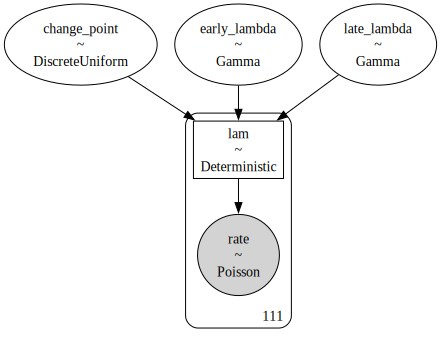

In [55]:
def coal_disaster_model():

    with pm.Model() as model:
        early_lambda = pm.Gamma('early_lambda', 1, 1)
        late_lambda = pm.Gamma('late_lambda', 1, 1)
        change_point = pm.DiscreteUniform('change_point', 1851, 1962)
        
        lam = pm.Deterministic('lam', pm.math.switch(years > change_point, late_lambda, early_lambda))
        pm.Poisson('rate', lam, observed=disasters_array)

    return model

pm.model_to_graphviz(coal_disaster_model())

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1$, $\lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(y_{t<\tau} | \lambda_1, \tau) P(y_{t\ge \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

So far so good! Now here's an implementation!

In [52]:
def gamma_pdf(lam, a, b):
    return lam**(a - 1) * np.exp(-b * lam)


def gibbs_sample_disaster(samples, tau=1900, early_lambda=6, late_lambda=2):
    draws = np.empty((3, samples))
    n_years = disasters_array.shape[0]
    years = np.arange(1851, 1962, dtype=int)
    for i in range(samples):
        # update early_lambda
        early_lambda = np.random.gamma(disasters_array[:tau - 1851].sum() + 1, 1 / (tau - 1851 + 10))
        draws[0, i] = early_lambda
        
        # update late_lambda
        late_lambda = np.random.gamma(disasters_array[tau - 1851 + 1:].sum() + 1, 1 / (1962 - tau + 10))
        draws[1, i] = late_lambda
        
        # update tau
        tau_probs = np.empty(n_years)
        for t in range(n_years):
            tau_probs[t] = (gamma_pdf(early_lambda, disasters_array[:t].sum() + 1, t + 10) *
                            gamma_pdf(late_lambda, disasters_array[t:].sum() + 1, n_years - t + 10))
        tau = np.random.choice(years, p=tau_probs / tau_probs.sum())
        draws[2, i] = tau

    return draws 


### Checking our work

We compare the Gibbs sampler to the PyMC model -- this one runs faster, but took longer to write!

In [53]:
%%time
draws = gibbs_sample_disaster(1000)
mean_values = draws.mean(axis=1)
print(f"Mean values: early_lambda: {mean_values[0]:.4f}, late_lambda: {mean_values[1]:.4f}, change_point: {mean_values[2]:.1f}")

Mean values: early_lambda: 2.4763, late_lambda: 0.7915, change_point: 1893.3
CPU times: user 560 ms, sys: 8.82 ms, total: 569 ms
Wall time: 561 ms


In [56]:
with coal_disaster_model() as model:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [57]:
az.summary(trace, var_names=['early_lambda', 'late_lambda', 'change_point', ])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_lambda,3.058,0.283,2.544,3.591,0.006,0.005,2478.0,2487.0,1.00
late_lambda,0.936,0.115,0.731,1.160,0.002,0.002,3358.0,2857.0,1.00
change_point,1889.994,2.491,1886.000,1895.000,0.115,0.097,510.0,274.0,1.01


## Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings (and Gibbs) sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. Random walk methods have trouble finding and traversing this set efficiently. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

HMC introduces two key concepts:

1. **Momentum variables**: In addition to position variables (our parameters of interest), HMC introduces momentum variables, creating a phase space.
2. **Hamiltonian dynamics**: It uses physical dynamics to guide proposals along trajectories that maintain constant energy.

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

![Skate park](images/skate_park.png?raw=true)

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

### No-U-Turn Sampler (NUTS)

A key challenge with HMC is selecting appropriate values for the step size $\epsilon$ and number of steps $L$. The No-U-Turn Sampler (NUTS) addresses this by:

1. **Adaptively tuning the step size** during a warm-up phase to achieve a target acceptance rate
2. **Dynamically determining the number of steps** by running the leapfrog integrator until a U-turn occurs (when the trajectory starts moving back toward its starting point)

NUTS builds a binary tree of leapfrog steps and stops when the trajectory makes a U-turn. For each proposal, it starts with a single leapfrog step.
It then doubles the length of the trajectory, simulating Hamiltonian dynamics both forwards and backwards in "time" from the current endpoints. This creates a balanced binary tree of states. It continues extending the trajectory by doubling the number of steps, subject to several conditions (related to detailed balance and ensuring good exploration). 
Once the doubling process stops (e.g., a U-turn is detected or a maximum tree depth is reached), a point is randomly sampled from all the states in the generated trajectory, with probabilities that ensure the overall sampler is valid.

![](images/uturn.png)

PyMC implements NUTS as its default sampler because of its efficiency for a wide range of problems. Let's see how to use it in practice:

## MCMC in PyMC

PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

The user's interface to PyMC's sampling algorithms is the `sample` function, which coordinates the sampling process for a model:

In [59]:
with coal_disaster_model() as model:
    trace = pm.sample(1000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


### Supported sampling methods

PyMC offers a range of sampling methods to accommodate different model requirements:

1. **NUTS (No U-Turn Sampler)** - The default for continuous variables, an advanced HMC variant that automatically tunes parameters

2. **HamiltonianMC** - Basic Hamiltonian Monte Carlo implementation for continuous variables

3. **Metropolis** - Classic Metropolis-Hastings algorithm that can handle continuous and discrete variables

4. **BinaryMetropolis** - Specialized algorithm for binary (boolean) variables

5. **Slice** - Slice sampling algorithm

6. **SGMC (Stochastic Gradient MCMC)** - Methods that use gradient information for large datasets

The `sample` function generally selects the appropriate method automatically based on the variable types in your model, though you can manually specify methods if needed.There is rarely a reason to use `HamiltonianMC` rather than `NUTS`. It is the default sampler for continuous variables in PyMC.

### Automatic assignment of step methods

When `step` is not specified by the user, PyMC will assign step methods to variables automatically. To do so, each step method implements a class method called `Competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample()` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). The default value of `cores` is `None`, which will select the number of CPUs on your machine, to a maximum of 4. 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

```python
with test_score_model:
    trace = pm.sample(chains=4, cores=2)
```

Running $n$ iterations with $c$ chains will result in $c \times n$ samples.

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.

In [45]:
with coal_disaster_model() as model:
    # Sample 4 chains in parallel using 4 cores
    trace = pm.sample(1000, tune=1000, chains=4, cores=4)

## JAX-based Samplers

An alternative to PyMC's PyTensor-based samplers are samplers written in JAX. Using these samplers, all the operations needed to compute a posterior can be performed under JAX, reducing the Python overhead during sampling and leveraging all JAX performance improvements and features like the ability to sample on GPUs or TPUs.

PyMC offers NUTS JAX samplers via [NumPyro](https://num.pyro.ai/en/latest/index.html) or [Nutpie](https://github.com/pymc-devs/nutpie). Significantly, NumPyro and Nutpie can both be used because in PyMC the modeling language is decoupled from the inference methods; NumPyro and Nutpie only require a log-probability density function written in JAX. This demonstrates that samplers can be developed independently of PyMC and then be made available to users of the library.

The JAX samplers can be invoked using the `nuts_sampler` argument for `pm.sample`, either using the Numpyro backend or the Nutpie backend:

```python
pm.sample(nuts_sampler="numpyro")
```

or

```python
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"})
```

In [59]:
with coal_disaster_model() as model:
    # Use the Nutpie JAX sampler
    trace = pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"})

---
## References

Doucet, A., De Freitas, N., and Gordon, N. (2001), Sequential Monte Carlo Methods in Practice, Statistics for Engineering and Information Science, New York: Springer-Verlag.

Chapter 6 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)

Chapter 5 of [Albert, J. (2009). Bayesian computation with R.](http://www.amazon.com/Bayesian-Computation-R-Use/dp/0387922970)

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis, Second Edition (Chapman & Hall/CRC Texts in Statistical Science) (2nd ed.). Chapman and Hall/CRC.

Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 15 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

pymc      : 5.22.0
scipy     : 1.12.0
numpy     : 1.26.4
arviz     : 0.20.0
platform  : 1.0.8
matplotlib: 3.10.1

Watermark: 2.5.0

